#### !!!! DO NOT RUN THIS FIRST CELL UNLESS YOU HAVE THE SAME VENV PATH ISSUE THAT I DO

In [1]:
import sys
sys.path.append('/Users/tunadorable/local-repos/ng-video-lecture/venv/lib/python3.11/site-packages')

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
from typing import List
import math
import numpy as np
import matplotlib.pyplot as plt

#### !!!! ONLY FOR APPLE SILICON

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Simple implementation of matryoshka embeddings. Not really more useful than regular GPT yet

In [4]:
# hyperparameters
b = 4 # how many independent sequences will we process in parallel?
t = 16 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 50
lr = 3e-4 # learning rate for each backprop step
eval_iters = 20
h = 4 # number of attention heads
l = 4 # number of transormer layers
dropout = 0.2 # % of parameters to ignore every iteration
l2 = 0.01 # multiplier for our L2 norm to encourage sparsity

# embedding aka hidden dimension. this is the largest that th emodel will have
d = 32
power_of_d = int(math.log2(d))
# the smallest power of 2 we'll be considering as a matryoshka embedding
min_power = 2 # Starting from 2^min_power
nesting_list = [2**i for i in range(min_power, int(power_of_d) + 1)]
print(nesting_list)

[4, 8, 16, 32]


In [5]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [6]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
v = len(chars)
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [8]:
# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [9]:
# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - t, (b,))
    x = torch.stack([data[i:i+t] for i in ix])
    y = torch.stack([data[i+1:i+t+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [10]:
# so you can see what the tokenized data looks like
x,y = get_batch('train')
print("x ", x.shape, "\n", x)
print("y ", y.shape, "\n", y)

x  torch.Size([4, 16]) 
 tensor([[46, 39, 56, 60, 43, 57, 58,  1, 53, 44,  1, 58, 46, 47, 57,  1],
        [56,  1, 47, 58,  8,  0,  0, 14, 33, 15, 23, 21, 26, 19, 20, 13],
        [53, 52, 43, 11,  1, 39, 52, 42,  1, 61, 47, 58, 46,  1, 46, 47],
        [17, 51, 54, 43, 56, 53, 56,  1, 53, 44,  1, 30, 59, 57, 57, 47]],
       device='mps:0')
y  torch.Size([4, 16]) 
 tensor([[39, 56, 60, 43, 57, 58,  1, 53, 44,  1, 58, 46, 47, 57,  1, 49],
        [ 1, 47, 58,  8,  0,  0, 14, 33, 15, 23, 21, 26, 19, 20, 13, 25],
        [52, 43, 11,  1, 39, 52, 42,  1, 61, 47, 58, 46,  1, 46, 47, 51],
        [51, 54, 43, 56, 53, 56,  1, 53, 44,  1, 30, 59, 57, 57, 47, 39]],
       device='mps:0')


In [11]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval() # sets model to eval mode
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train() # just resets to training mode
    return out

In [12]:
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, d):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 4 * d),
            nn.ReLU(),
            nn.Linear(4 * d, d),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d, head_size, bias=False)
        self.query = nn.Linear(d, head_size, bias=False)
        self.value = nn.Linear(d, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(t, t))) # mask future timestesps
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        b,t,d = x.shape
        k = self.key(x)   # (b,t,d/h)
        q = self.query(x) # (b,t,d/h)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (b, t, d/h) @ (b, d/h, t) -> (b, t, t)
        wei = wei.masked_fill(self.tril[:t, :t] == 0, float('-inf')) # (b, t, t)
        wei = F.softmax(wei, dim=-1) # (b, t, t)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (b,t,d/h)
        out = wei @ v # (b, t, t) @ (b, t, d/h) -> (b, t, d/h)
        return out

In [14]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, h, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(h)])
        self.proj = nn.Linear(head_size * h, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [15]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, d, h):
        # d: embedding dimension, h: the number of heads we'd like
        super().__init__()
        head_size = d // h # the double backslash just makes the output an int instead of float
        self.sa = MultiHeadAttention(h, head_size)
        self.ffwd = FeedFoward(d)
        self.ln = nn.LayerNorm(d, elementwise_affine=False)

    def forward(self, x):
        x = x + self.sa(self.ln(x))
        x = x + self.ffwd(self.ln(x))
        return x

In [16]:
class Matryoshka_CE_Loss(nn.Module):
    '''
    Loss function for Matryoshka Representation Learning 
    '''
    def __init__(self, relative_importance: List[float]=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        
        # relative importance shape: [G]
        # this is optional for if you want to weight them differently
        self.relative_importance = relative_importance

    def forward(self, logits, target):
        # logits shape: [g granularities, b batch size, t sequence length, v number of classes]
        # EXCEPT IT COMES IN THE FORM OF A TUPLE OF TENSORS SO REALLY
        g = len(logits)
        b,t,v = logits[-1].shape
        # target shape: [b batch size, t sequence length]

        # Calculate losses for each output and stack them
        # might need to do .view() or .reshape() to make sure these go in well
        losses = torch.stack([self.criterion(logits_i.view(b*t, v), target.view(b*t)) for logits_i in logits])

        # Set relative_importance to 1 if not specified
        # I don't think i'm gonna be emssing around with this part
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.tensor(self.relative_importance)

        # Apply relative importance weights
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

### old, works but doesn't layernorm the embedding matrix
### very odd is after i switched to the new one the loss went up by a lot

```
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        
        # we can pass in a size (v,d) layer (such as the embedding matrix)
        if passed_in_layer is None:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        else:
            # Use the passed-in layer (embedding matrix) of shape (d,v) directly instead of creating a new learnable layer
            self.nesting_classifier_0 = passed_in_layer.to(device).t()
            
    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], self.nesting_classifier_0[:num_feat,:]), )
        
        return nesting_logits
```

In [18]:
class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list: List, num_classes=v, passed_in_layer=None, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes  # Number of classes for classification
        
        self.passed_in_layer = passed_in_layer  # Store reference to the embedding layer
        self.use_passed_in_layer = passed_in_layer is not None
        if not self.use_passed_in_layer:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, bias=False, device=device, **kwargs)
        
        # Initialize layer normalization
        self.layer_norm = nn.LayerNorm(nesting_list[-1], elementwise_affine=False)

    def forward(self, x):
        if self.use_passed_in_layer:
            # Apply layer normalization on the fly during the forward pass
            normed_passed_in_layer = self.layer_norm(self.passed_in_layer)
            nesting_classifier_0 = normed_passed_in_layer.t().to(x.device)
        else:
            nesting_classifier_0 = self.nesting_classifier_0

        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            nesting_logits += (torch.matmul(x[..., :num_feat], nesting_classifier_0[:num_feat, :]),)
        
        return nesting_logits

In [19]:
class matryoshka_embeddings_GPT(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(v, d).to(device)
        
        # simple learned positional encodings rather than sine or RoPE
        self.position_embedding_table = nn.Embedding(t, d) 
        self.blocks = nn.Sequential(*[Block(d, h) for _ in range(l)]) # bulk of the beast
        self.ln = nn.LayerNorm(d, elementwise_affine=False) # final layer norm

        # regular GPT output head
        #self.lm_head = self.token_embedding_table.weight.t()
        
        ### MATRYOSHKA OUTPUT HEADS
        self.m_head = MRL_Linear_Layer(nesting_list = nesting_list, passed_in_layer = self.token_embedding_table.weight)
        
        ### MATRYOSHKA LOSS
        self.m_loss = Matryoshka_CE_Loss()
        
        # initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        b, t = idx.shape
        
        # idx and targets are both (b,t) tensor of integers
        pos_emb = self.position_embedding_table(torch.arange(t, device=device)) # (t,d)
        tok_emb = self.token_embedding_table(idx) # (b,t,d)
        x = self.ln(tok_emb) + pos_emb
        #x = self.ln(tok_emb) + pos_emb # (b,t,d) + (t,d) = (b,t,d)
        x = self.blocks(x) # (b,t,d) -> (b,t,d)
        x = self.ln(x) # (b,t,d) -> (b,t,d)

        # regular GPT output head
        #logits = self.lm_head(x)
        # Matryoshka output head
        logits = self.m_head(x) # tensor [b,t,d] -> tuple ([b,t,d_0], [b,t,d_1], [b,t,d_2],..., [b,t,d_g])
        
        if targets is None:
            loss = None
        else:
            loss = self.m_loss(logits, targets) # (g,b,t,d) & (b,t) -> float

        return logits, loss

    def generate(self, idx, max_new_tokens, degree=power_of_d):
        assert degree >= min_power & degree <= power_of_d
        # idx is (b, t) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -t:]
            # get the predictions
            logits, loss = self(idx_cond)
            # select the desired degree
            logits = logits[degree-min_power]
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (b, d)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (b, d)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (b, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (b, t+1)
        return idx

In [20]:
model = matryoshka_embeddings_GPT().to(device)
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2)
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e3, 'K parameters')

52.512 K parameters


In [21]:
start_time = time.time()

# Enable anomaly detection
#torch.autograd.set_detect_anomaly(True)

for iter in range(max_iters):

    # sample a batch of data
    xb, yb = get_batch('train')
    
    # train
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        current_time = time.time()
        elapsed_time = current_time - start_time
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, time elapsed: {elapsed_time:.2f} seconds")

# Disable anomaly detection after the training loop
#torch.autograd.set_detect_anomaly(False)

step 0: train loss 58.9902, val loss 58.6571, time elapsed: 1.16 seconds
step 50: train loss 23.0591, val loss 24.0754, time elapsed: 7.71 seconds
step 100: train loss 15.8945, val loss 16.1734, time elapsed: 14.15 seconds
step 150: train loss 14.3020, val loss 14.4659, time elapsed: 20.93 seconds
step 200: train loss 13.6062, val loss 13.6072, time elapsed: 27.42 seconds
step 250: train loss 13.2944, val loss 13.7038, time elapsed: 33.96 seconds
step 300: train loss 13.0589, val loss 13.1008, time elapsed: 40.41 seconds
step 350: train loss 12.9951, val loss 13.0449, time elapsed: 46.82 seconds
step 400: train loss 13.0494, val loss 12.8113, time elapsed: 53.26 seconds
step 450: train loss 12.8113, val loss 13.0358, time elapsed: 59.63 seconds
step 500: train loss 12.6075, val loss 12.4897, time elapsed: 66.07 seconds
step 550: train loss 12.7125, val loss 12.5226, time elapsed: 72.54 seconds
step 600: train loss 12.7178, val loss 12.4586, time elapsed: 78.93 seconds
step 650: train l

In [22]:
## save the trained model
torch.save(model.state_dict(), f'models/{model.__class__.__name__}_b{b}_t{t}_d{d}_h{h}_l{l}_lr{lr}_drop{dropout}_l2-{l2}_min_power{min_power}_{time.strftime("%Y-%m-%d|%H-%M-%S")}.pth')

RuntimeError: Parent directory models does not exist.

# Load a saved model

In [ ]:
model = matryoshka GPT().to(device)  # Initialize a model with the same architecture

# Load the saved state dictionary
model.load_state_dict(torch.load('models/GPT_b24_t128_d128_h8_l8_lr0.0003_drop0.2_l2-0.01_2024-01-25|23-31-12.pth'))

# If you plan to continue training the model, switch to training mode
#model.train()

# If you only plan to do inference, switch to evaluation mode
model.eval()

# Inference

In [135]:
%%time
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
output = model.generate(context_tensor, max_new_tokens=100, degree = min_power)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou R wareeae au
S'lranwol om hrsAEEnbl e foatonmeeonelon!
S, wsglwe, nmr, ahantale, nto; dakkld s? Bno h
CPU times: user 9.11 s, sys: 1.91 s, total: 11 s
Wall time: 11.1 s


In [147]:
%%time
input_str = "JULIET:\nO Romeo, Romeo! wherefore art thou R" # the classic line
context_tensor = torch.tensor([encode(input_str)], dtype=torch.long, device=device)
output = model.generate(context_tensor, max_new_tokens=100, degree = power_of_d)
output_str = decode(output[0].tolist())
print(output_str)

JULIET:
O Romeo, Romeo! wherefore art thou Rhapl' rus krrrabeue, orikeed thay mars, sork,
Ses be
Whep, Foreeeey mere frthal:
Thepp thhite tous:

CPU times: user 9.13 s, sys: 1.95 s, total: 11.1 s
Wall time: 11.2 s


# analyzing token & concept embedding vectors

In [148]:
# Access the embedding weight matrix
embedding_matrix = model.token_embedding_table.weight.data

# If you want to look at the embedding for a specific token index, say index 42
token = 'a'
token_index = stoi[token]
token_embedding = embedding_matrix[token_index]

print(f"Embedding for token '{token}' index {token_index}: {token_embedding}")

Embedding for token 'a' index 39: tensor([-0.0139,  0.0181, -0.0566, -0.0125, -0.0072,  0.0316, -0.0333,  0.0078,
         0.0064, -0.0023, -0.0078,  0.0224, -0.0160,  0.0089,  0.0234,  0.0327,
         0.0269,  0.0144,  0.0162,  0.0562,  0.0432, -0.0017,  0.0294,  0.0427,
        -0.0026, -0.0513, -0.0074, -0.0229,  0.0359,  0.0095, -0.0288,  0.0029],
       device='mps:0')


In [149]:
def cosine_similarity(embedding1, embedding2):
    # Calculate the cosine similarity between two embeddings
    return F.cosine_similarity(embedding1.unsqueeze(0), embedding2.unsqueeze(0))

# Example tokens
token1 = 'a'
token2 = 'b'
token3 = 'i'
token4 = 'A'
token5 = '.'

# Convert tokens to indices
index1 = stoi[token1]
index2 = stoi[token2]
index3 = stoi[token3]
index4 = stoi[token4]
index5 = stoi[token5]

# Retrieve embeddings from the model
embedding1 = model.token_embedding_table.weight[index1]
embedding2 = model.token_embedding_table.weight[index2]
embedding3 = model.token_embedding_table.weight[index3]
embedding4 = model.token_embedding_table.weight[index4]
embedding5 = model.token_embedding_table.weight[index5]

# Calculate cosine similarity
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding2[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token2}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding3[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token3}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding4[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token4}':", similarity.item())
for i, degree in enumerate(nesting_list):
    similarity = cosine_similarity(embedding1[:degree], embedding5[:degree])
    print(f"degree {degree} Cosine similarity between '{token1}' and '{token5}':", similarity.item())

degree 4 Cosine similarity between 'a' and 'b': 0.7897742390632629
degree 8 Cosine similarity between 'a' and 'b': 0.5561302304267883
degree 16 Cosine similarity between 'a' and 'b': 0.34317511320114136
degree 32 Cosine similarity between 'a' and 'b': 0.6525861620903015
degree 4 Cosine similarity between 'a' and 'i': 0.9846053719520569
degree 8 Cosine similarity between 'a' and 'i': 0.9585959315299988
degree 16 Cosine similarity between 'a' and 'i': 0.9261179566383362
degree 32 Cosine similarity between 'a' and 'i': 0.9255014657974243
degree 4 Cosine similarity between 'a' and 'A': -0.6012901067733765
degree 8 Cosine similarity between 'a' and 'A': -0.36448532342910767
degree 16 Cosine similarity between 'a' and 'A': -0.07144127041101456
degree 32 Cosine similarity between 'a' and 'A': 0.4007250666618347
degree 4 Cosine similarity between 'a' and '.': 0.20061975717544556
degree 8 Cosine similarity between 'a' and '.': -0.07954929023981094
degree 16 Cosine similarity between 'a' and '.'

In [150]:
def plot_token_similarity(tokens, model, stoi, degree, nesting_list=nesting_list, size=6):
    # Initialize a matrix to store cosine similarities
    similarity_matrix = np.zeros((len(tokens), len(tokens)))

    degree = nesting_list[degree-min_power]
    
    # Calculate cosine similarity for each pair of tokens
    for i, token1 in enumerate(tokens):
        for j, token2 in enumerate(tokens):
            index1 = stoi[token1]
            index2 = stoi[token2]
            embedding1 = model.token_embedding_table.weight[index1]
            embedding2 = model.token_embedding_table.weight[index2]
            similarity = F.cosine_similarity(embedding1[:degree].unsqueeze(0), embedding2[:degree].unsqueeze(0))
            similarity_matrix[i, j] = similarity.item()
    
    # Plotting
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(similarity_matrix, cmap='viridis', vmin=-1, vmax=1)
    fig.colorbar(cax)

    # Set axis labels to the tokens
    ax.set_xticks(np.arange(len(tokens)))
    ax.set_yticks(np.arange(len(tokens)))
    ax.set_xticklabels(tokens)
    ax.set_yticklabels(tokens)

    # Label axes
    ax.set_xlabel('Tokens')
    ax.set_ylabel('Tokens')
    ax.set_title(f'Cosine Similarity Between Token Embeddings of degree {degree}')

    # Show the plot
    plt.show()

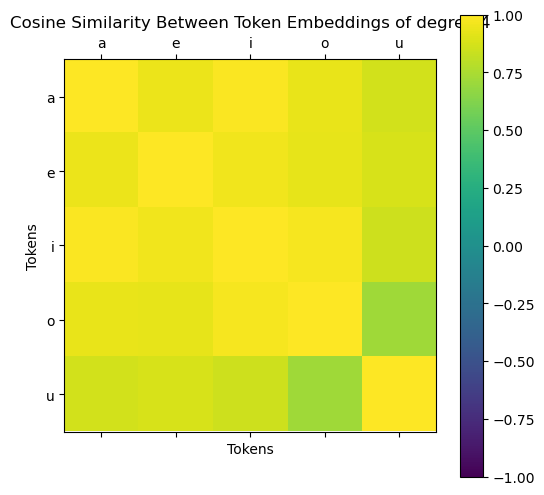

In [151]:
# Example usage with vowels
vowels = ['a', 'e', 'i', 'o', 'u']
plot_token_similarity(vowels, model, stoi, degree=min_power)

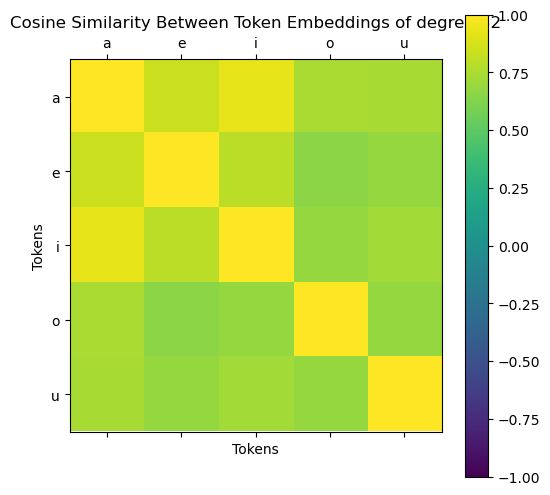

In [152]:
plot_token_similarity(vowels, model, stoi, degree=power_of_d)

In [153]:
# reordering chars so that it more clearly shows some of the categories i expect to emerge
chars1 = ['\n', 
          '!','.','?', 
          ' ', '$', '&', "'", ',', '-', '3', ':', ';',
        'A', 'E', 'I', 'O', 'U', 
        'B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z',
        'a', 'e', 'i', 'o', 'u', 
        'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

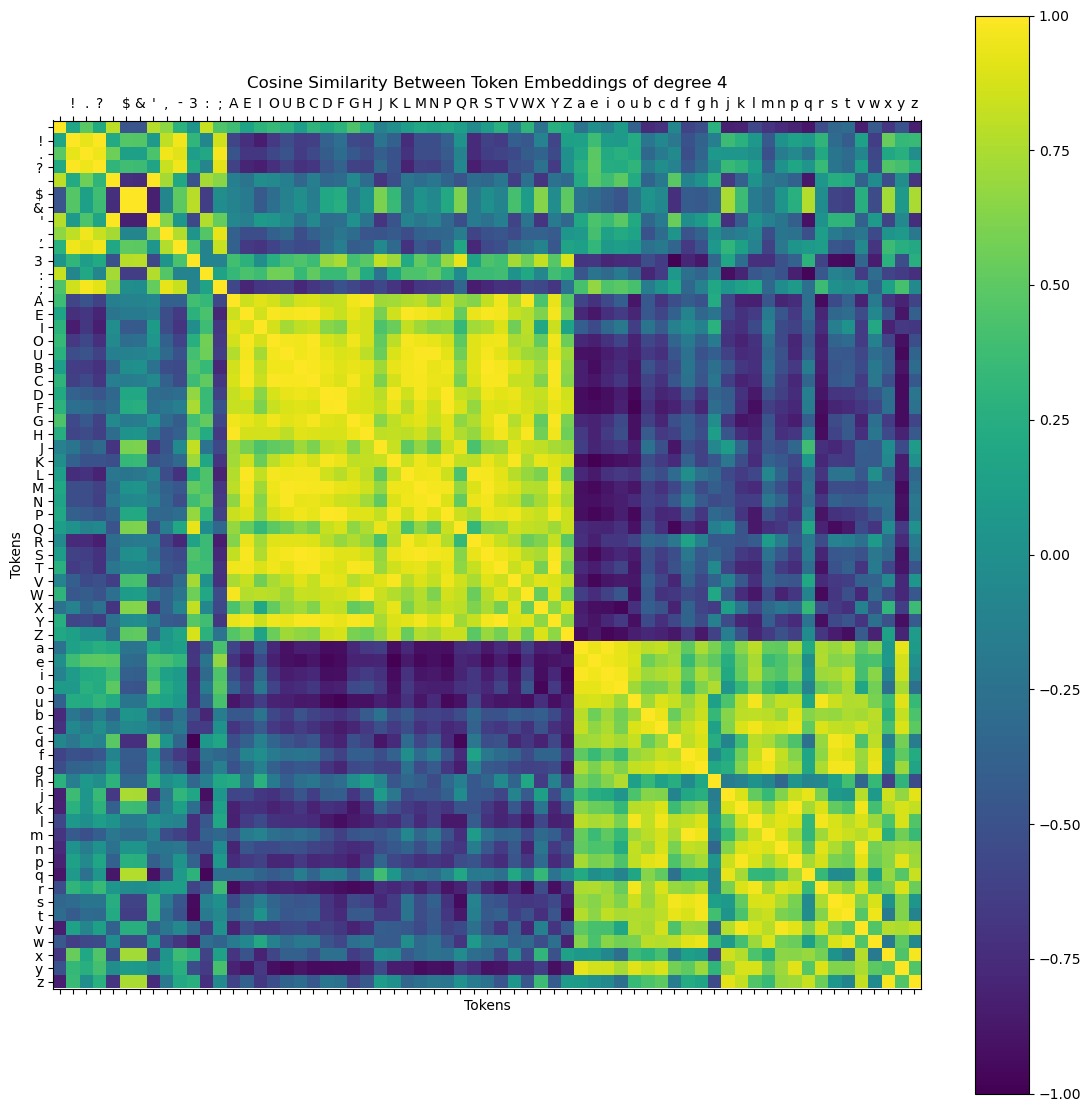

In [154]:
plot_token_similarity(chars1, model, stoi, degree=min_power, size=14)

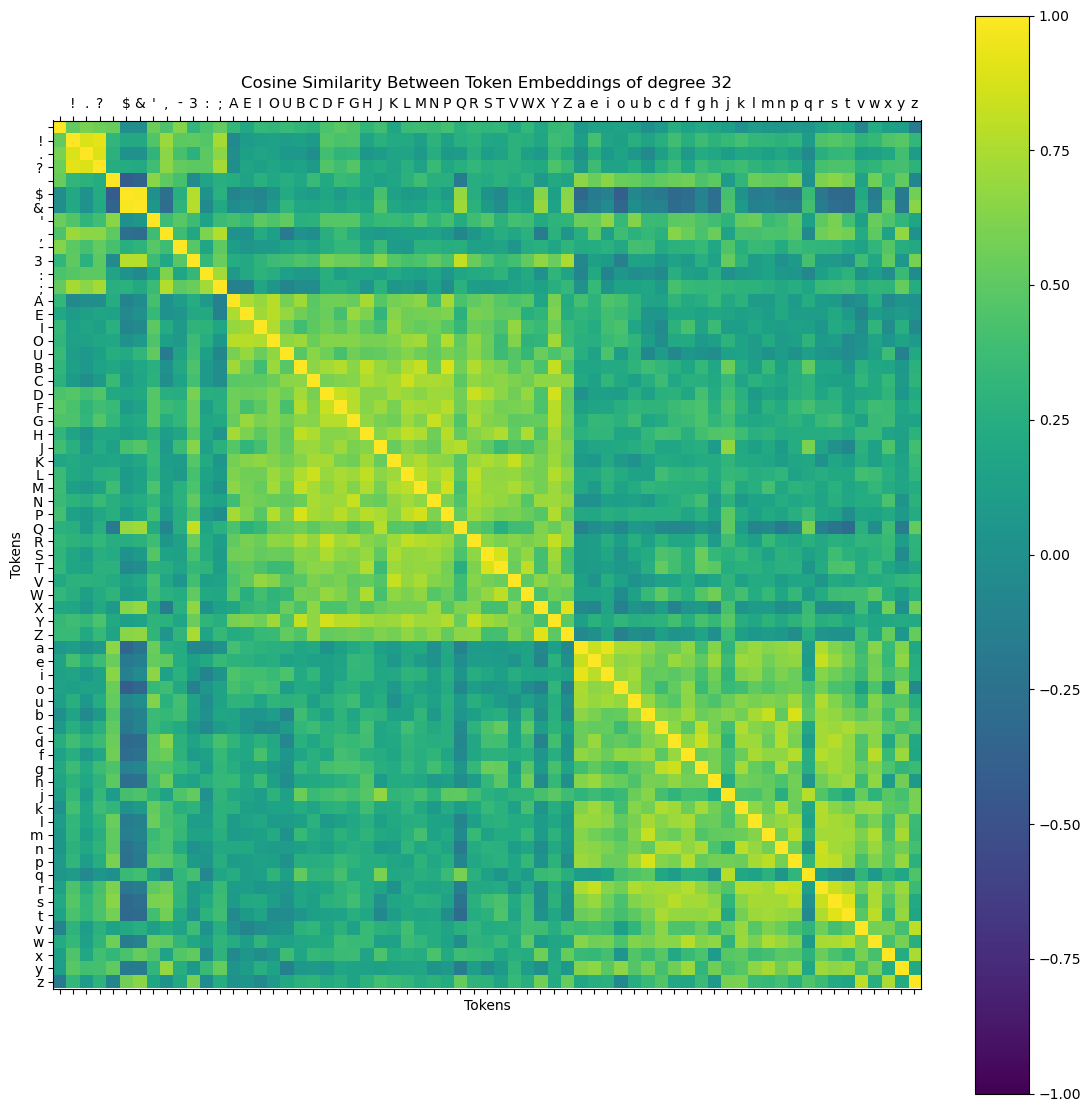

In [155]:
plot_token_similarity(chars1, model, stoi, degree=power_of_d, size=14)

# creating a semantic hierarchy of tokens to impose on the model

In [185]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
print(chars, v)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 65


In [186]:
non_alphabetical = ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?']
# 3 disjoint branches within
endofsentence = ['!','.','?']
mid_sentence = [' ', '$', '&', "'", ',', '-', '3', ':', ';']
other_non_alphabetical = ['\n']
# notice how there are other ways to organize these. here we are imposing our graph structure onto the model, which will be sub-optimal

###### FUNDAMENTAL SCHISM IS BW ALPHABETICAL & NON-ALPHABETICAL

uppercase = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
lowercase = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
vowels = ['A', 'a', 'E', 'e', 'I', 'i', 'O', 'o', 'U', 'u', 'Y', 'y']
consonants = ['B', 'b', 'C', 'c', 'D', 'd', 'F', 'f', 'G', 'g', 'H', 'h', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'P', 'p', 'Q', 'q', 'R', 'r', 'S', 's', 'T', 't', 'V', 'v', 'W', 'w', 'X', 'x', 'Y', 'y', 'Z', 'z']
uppercase_vowels = ['A', 'E', 'I', 'O', 'U', 'Y']
lowercase_vowels = ['a', 'e', 'i', 'o', 'u', 'y']
uppercase_consonants = ['B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z']
lowercase_consonants = ['b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'w', 'x', 'y', 'z']

# allowing the model to show us its own token hierarchy

so i'm thinking that we monitor cosine similarity of the shortest embedding vectors. then somehow we do a clustering thing that is completely binary, meaning it can only separate into two different groups. we somehow use cosine similarity to identify these two clusters, and then "separate" them meaning we switch the loss function to only better predict these two primary categories. Then repeat for the remaining values in the next length embedding vector. Then eventually we get a reasonable amount of splits. To prevent that same behavior from splitting infintiely we need some kind of minimum criteria to trigger a split. but then how do we create the combination relationships, such as mapping capital letters to their lowercase versions? I think instead of splitting we create some separate measure that's combining vectors that are already on a separate tree from each other. For example, if the first $d_0$ entries determine alphanumeric vs symbol, then the next $d_1$ determines letters vs numbers (in the case of alphanumeric), then the next $d_2$ determines capital vs lowercase (in the case of letters) then now that capital & lowercase have split, the next $d_3$ have the option to recombine a capital letter with its lowercase version & group them together

chatGPT's attempt at the matryoshkaFeedForward(). supposedly it's more efficient bc my use of .weight on the linear layers was 
stupid, and it also has the benefit of bringing back bias vectors. Honestly yeah it does look better than mine i think i should try it after i confirm that mine bare-minimum functions

```
class MatryoshkaFeedForward(nn.Module):
    def __init__(self, nesting_list, dropout_rate):
        super().__init__()
        
        # The largest embedding dimension of the model
        self.d = nesting_list[-1]

        # Initialize only the largest weights and biases
        self.weight_w1 = nn.Parameter(torch.Tensor(4 * self.d, self.d))
        self.bias_w1 = nn.Parameter(torch.Tensor(4 * self.d))
        self.weight_w2 = nn.Parameter(torch.Tensor(self.d, 4 * self.d))
        self.bias_w2 = nn.Parameter(torch.Tensor(self.d))

        # Initialize weights and biases
        self.reset_parameters()

        self.nesting_list = nesting_list
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(dropout_rate)

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight_w1, a=math.sqrt(5))  # or any other initialization
        nn.init.kaiming_uniform_(self.weight_w2, a=math.sqrt(5))  # or any other initialization
        fan_in1, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_w1)
        bound1 = 1 / math.sqrt(fan_in1)
        nn.init.uniform_(self.bias_w1, -bound1, bound1)
        fan_in2, _ = nn.init._calculate_fan_in_and_fan_out(self.weight_w2)
        bound2 = 1 / math.sqrt(fan_in2)
        nn.init.uniform_(self.bias_w2, -bound2, bound2)

    def forward(self, x_0):
        x_f = ()
        for i, d_i in enumerate(self.nesting_list):
            # Subset the weights and biases
            weight_w1_sub = self.weight_w1[:4 * d_i, :d_i]
            bias_w1_sub = self.bias_w1[:4 * d_i]
            weight_w2_sub = self.weight_w2[:d_i, :4 * d_i]
            bias_w2_sub = self.bias_w2[:d_i]

            # Apply the linear transformations using the subset weights and biases
            x = F.linear(x_0[i], weight_w1_sub, bias_w1_sub)
            x = self.relu(x)
            x = F.linear(x, weight_w2_sub, bias_w2_sub)
            x = self.drop(x)
            x_f += (x,)

        return x_f
```